# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import skopt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import  RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import xgboost as xgbc
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, f1_score, roc_auc_score
# magic word for producing visualizations in notebook
%matplotlib inline


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [1]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')


In [2]:
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [7]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [8]:
azdias.shape

(891221, 366)

In [9]:
#check column names for columns having mixed types
azdias.iloc[:,18:20].columns

Index(['CAMEO_DEUG_2015', 'CAMEO_INTL_2015'], dtype='object')

In [10]:
#display unique values for CAMEO_DEUG_2015
azdias.CAMEO_DEUG_2015.unique()

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [11]:
#display unique values for CAMEO_INTL_2015
azdias.CAMEO_INTL_2015.unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'],
      dtype=object)

In [12]:
#display unique values for CAMEO_DEUG_2015
customers.CAMEO_DEUG_2015.unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [13]:
#display unique values for CAMEO_INTL_2015
customers.CAMEO_INTL_2015.unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

We can see that there are different types of values in columns CAMEO_INTL_2015 and CAMEO_DEUG_2015: float and string. There are also some values: 'X' and 'XX' which should be replaced with nulls.



The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [10]:
# replace 'X' with null and set column type as float for all CAMEO_DEUG_2015 column values
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace({'X':np.nan}).astype(float)
    

In [11]:
#display unique values for CAMEO_DEUG_2015 after fixing data
azdias.CAMEO_DEUG_2015.unique()

array([nan,  8.,  4.,  2.,  6.,  1.,  9.,  5.,  7.,  3.])

In [12]:
# replace 'XX' with null and set column type as float for all CAMEO_INTL_2015 column values
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace({'XX':np.nan}).astype(float)

In [17]:
#display unique values for CAMEO_INTL_2015 after fixing data
azdias.CAMEO_INTL_2015.unique()

array([nan, 51., 24., 12., 43., 54., 22., 14., 13., 15., 33., 41., 34.,
       55., 25., 23., 31., 52., 35., 45., 44., 32.])

In [18]:
# check number of columns and rows for azdias dataset
azdias.shape

(891221, 366)

In [19]:
customers.CAMEO_INTL_2015.unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

In [20]:
customers.CAMEO_DEUG_2015.unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [13]:
# replace 'X' with null and set column type as float for all CAMEO_DEUG_2015 column values
customers['CAMEO_DEUG_2015'] = customers['CAMEO_DEUG_2015'].replace({'X':np.nan}).astype(float)
 

In [22]:
customers.CAMEO_DEUG_2015.unique()

array([ 1., nan,  5.,  4.,  7.,  3.,  9.,  2.,  6.,  8.])

In [14]:
# replace 'XX' with null and set column type as float for all CAMEO_INTL_2015 column values
customers['CAMEO_INTL_2015'] = customers['CAMEO_INTL_2015'].replace({'XX':np.nan}).astype(float)

In [24]:
customers.CAMEO_INTL_2015.unique()

array([13., nan, 34., 24., 41., 23., 15., 55., 14., 22., 43., 51., 33.,
       25., 44., 54., 32., 12., 35., 31., 45., 52.])

In [25]:
# check number of columns and rows for customers dataset
customers.shape

(191652, 369)

In [15]:
#drop additional 3 columns from customers dataset which are not available in azdias dataset
customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [27]:
# check number of columns and rows for customers dataset after removing columns
customers.shape

(191652, 366)

In [28]:
# display column names of azdias dataset
list(azdias.columns)

['LNR',
 'AGER_TYP',
 'AKT_DAT_KL',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE

In [16]:
#checking if the set of columns is the same in both datasets (azdias and customers)
set(azdias.columns) == set(customers.columns)

True

In [17]:
#checking if the set of columns is the same in both datasets (azdias and customers) - second method
set(azdias.columns) - set(customers.columns)

set()

In both datasets there is the same set of columns.

In [31]:
# count of nulls
azdias_nan_count = azdias.isnull().sum()

In [32]:
azdias_nan_count

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     73499
ALTER_HH                       73499
ALTER_KIND1                   810163
ALTER_KIND2                   861722
ALTER_KIND3                   885051
ALTER_KIND4                   890016
ALTERSKATEGORIE_FEIN          262947
ANZ_HAUSHALTE_AKTIV            93148
ANZ_HH_TITEL                   97008
ANZ_KINDER                     73499
ANZ_PERSONEN                   73499
ANZ_STATISTISCHE_HAUSHALTE     93148
ANZ_TITEL                      73499
ARBEIT                         97216
BALLRAUM                       93740
CAMEO_DEU_2015                 98979
CAMEO_DEUG_2015                99352
CAMEO_INTL_2015                99352
CJT_GESAMTTYP                   4854
CJT_KATALOGNUTZER               4854
CJT_TYP_1                       4854
CJT_TYP_2                       4854
CJT_TYP_3                       4854
CJT_TYP_4                       4854
CJT_TYP_5                       4854
C

In [279]:
# count of nulls
customers_nan_count = customers.isnull().sum()

In [12]:
def percent_nulls(df):
    '''
    function to calculate percentage of missing values per column
    INPUT: df - pandas dataframe
    OUTPUT: df_nan_perc - table with percentage of nulls per column
    '''
    df_nan = df.isnull().mean()*100
    df_nan_perc = pd.DataFrame({'col_name': df.columns,'percent_nulls': df_nan})

    return df_nan_perc

In [34]:
azdias_percent_nulls = percent_nulls(azdias)

In [35]:
azdias_percent_nulls.sort_values('percent_nulls', ascending=False)

,col_name,percent_nulls
ALTER_KIND4,ALTER_KIND4,99.864792
ALTER_KIND3,ALTER_KIND3,99.307691
ALTER_KIND2,ALTER_KIND2,96.690047
ALTER_KIND1,ALTER_KIND1,90.904837
EXTSEL992,EXTSEL992,73.399639
KK_KUNDENTYP,KK_KUNDENTYP,65.596749
ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_FEIN,29.504130
D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,28.849522
D19_LOTTO,D19_LOTTO,28.849522
D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,28.849522


In [36]:
# percentage of nulls for customers
customers_percent_nulls = percent_nulls(customers)

In [37]:
# sort percentage of nulls dataframe
customers_percent_nulls.sort_values('percent_nulls', ascending=False)

,col_name,percent_nulls
ALTER_KIND4,ALTER_KIND4,99.876860
ALTER_KIND3,ALTER_KIND3,99.334732
ALTER_KIND2,ALTER_KIND2,97.338927
ALTER_KIND1,ALTER_KIND1,93.860748
KK_KUNDENTYP,KK_KUNDENTYP,58.406382
EXTSEL992,EXTSEL992,44.498883
KBA05_HERST4,KBA05_HERST4,29.209192
KBA05_FRAU,KBA05_FRAU,29.209192
KBA05_GBZ,KBA05_GBZ,29.209192
KBA05_HERST1,KBA05_HERST1,29.209192


In [38]:
azdias.shape

(891221, 366)

In [40]:
 # drop columns if All the Values are Null - these columns are not useful and do not provide any insights
azdias = azdias.dropna(how='all', axis=1)

In [58]:
azdias.shape

(891221, 366)

In [62]:
customers.shape

(191652, 366)

In [61]:
# drop columns if All the Values are Null - these columns are not useful and do not provide any insights
customers = customers.dropna(how='all', axis=1)

In [ ]:
customers.shape

In [63]:
#check duplicates
azdias.duplicated(keep='first').sum()

0

In [ ]:
# check number of duplicates
customers.duplicated(keep='first').sum()

In [29]:
#find objcets in azdias dataset
azdias.select_dtypes(include='object').head()

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,NaN,1992-02-10 00:00:00,W
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,D19_SCHUHE,1992-02-12 00:00:00,W


In [13]:
#load dias attributes data from excel file

dias_attr = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=[0])

In [14]:
dias_attr.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [15]:
# delete Unnamed column
del dias_attr['Unnamed: 0']

In [16]:
dias_attr.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [17]:
# find indices for uknowns in the dias attribute dataset
ind = np.where((dias_attr.Meaning == 'unknown') | (dias_attr.Meaning == 'unknown / no main age detectable') )

In [18]:
dias_df = dias_attr.loc[ind]
dias_df.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
131,CJT_GESAMTTYP,customer journey typology,0,unknown
391,D19_KK_KUNDENTYP,consumption movement in the last 12 months,-1,unknown


In [19]:
dias_df.Value.unique()

array([-1, '-1, 0', 0, '-1, 9', '-1'], dtype=object)

In [20]:
dias_atrr_val = dias_df[['Attribute','Value']]
dias_atrr_val.head(10)

,Attribute,Value
0,AGER_TYP,-1
5,ALTERSKATEGORIE_GROB,"-1, 0"
11,ALTER_HH,0
33,ANREDE_KZ,"-1, 0"
40,BALLRAUM,-1
48,BIP_FLAG,-1
51,CAMEO_DEUG_2015,-1
105,CAMEO_DEUINTL_2015,-1
131,CJT_GESAMTTYP,0
391,D19_KK_KUNDENTYP,-1


In [21]:
dias_atrr_val = pd.DataFrame(dias_atrr_val)

In [22]:
dias_atrr_val.Value.unique()

array([-1, '-1, 0', 0, '-1, 9', '-1'], dtype=object)

In [23]:
dias_atrr_val[dias_atrr_val['Value'] == '-1']

,Attribute,Value
2003,ORTSGR_KLS9,-1


In [24]:
# replace string into integer
dias_atrr_val['Value'] = dias_atrr_val['Value'].replace({'-1':-1})

In [25]:
dias_atrr_val.Value.unique()

array([-1, '-1, 0', 0, '-1, 9'], dtype=object)

In [26]:
#split unknown values into seperate columns
att = pd.concat([dias_atrr_val,dias_atrr_val['Value'].str.split(',', expand=True)],axis=1)
att.columns = ['Attribute','Value','Val2','Val3']
att

,Attribute,Value,Val2,Val3
0,AGER_TYP,-1,NaN,NaN
5,ALTERSKATEGORIE_GROB,"-1, 0",-1,0
11,ALTER_HH,0,NaN,NaN
33,ANREDE_KZ,"-1, 0",-1,0
40,BALLRAUM,-1,NaN,NaN
...,...,...,...,...
2219,WOHNDAUER_2008,"-1, 0",-1,0
2229,WOHNLAGE,-1,NaN,NaN
2238,WACHSTUMSGEBIET_NB,"-1, 0",-1,0
2244,W_KEIT_KIND_HH,"-1, 0",-1,0


In [27]:
att.Val2.unique()

array([nan, '-1'], dtype=object)

In [28]:
att.Val3.unique()

array([nan, ' 0', ' 9'], dtype=object)

In [29]:
#change type for Val2 and Val3 into float
att.Val3 = att.Val3.astype(float);
att.Val2 = att.Val2.astype(float);

In [30]:
att.Val2.unique()

array([nan, -1.])

In [31]:
att.Val3.unique()

array([nan,  0.,  9.])

In [32]:
att.dtypes

Attribute     object
Value         object
Val2         float64
Val3         float64
dtype: object

In [33]:
att_tr = att.transpose()
att_tr.columns = att_tr.iloc[0]

In [34]:
att_tr.drop(index = att_tr.index[0],axis =0,inplace=True)

In [35]:
att_tr

Attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ALTER_HH,ANREDE_KZ,BALLRAUM,BIP_FLAG,CAMEO_DEUG_2015,CAMEO_DEUINTL_2015,CJT_GESAMTTYP,D19_KK_KUNDENTYP,...,SEMIO_VERT,SHOPPER_TYP,SOHO_FLAG,TITEL_KZ,VERS_TYP,WOHNDAUER_2008,WOHNLAGE,WACHSTUMSGEBIET_NB,W_KEIT_KIND_HH,ZABEOTYP
Value,-1,"-1, 0",0,"-1, 0",-1,-1,-1,-1,0,-1,...,"-1, 9",-1,-1,"-1, 0",-1,"-1, 0",-1,"-1, 0","-1, 0","-1, 9"
Val2,NaN,-1.0,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.0,NaN,NaN,-1.0,NaN,-1.0,NaN,-1.0,-1.0,-1.0
Val3,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,0.0,9.0


In [36]:
def add_missing_values(df, unknown_df):
    '''
    function finds unknown values and replaces them with null values
    INPUT: df - dataframe where we replace unknown values with nulls
           unknown_df = dataframe with attributes and values for particular attribute -
           the value indicates that this is unknown and should be replace with null
           
    '''
    for attribute in unknown_df:
        if attribute in df:
            for nan_val in unknown_df[attribute]:
                df[attribute].replace(nan_val, np.nan, inplace=True)
                


In [39]:
# additionally we replce uniformly distributed values with nulls for ALTERSKATEGORIE_GROB                
azdias['ALTERSKATEGORIE_GROB'].replace(9, np.nan, inplace=True) 

In [40]:
# apply add_missing_values to azdias dataset
add_missing_values(azdias,att_tr)

In [39]:
# apply add_missing_values to customers dataset
add_missing_values(customers,att_tr)

In [40]:
# replace 9 with nulls for 'ALTERSKATEGORIE_GROB' in customers data set
customers['ALTERSKATEGORIE_GROB'].replace(9, np.nan, inplace=True) 

In [41]:
# check percentage of nulls in azdias
azdias_percent_nulls = percent_nulls(azdias)

In [42]:
azdias_percent_nulls[azdias_percent_nulls.percent_nulls >= 27].sort_values('percent_nulls')

,col_name,percent_nulls
D19_KONSUMTYP,D19_KONSUMTYP,28.849522
D19_VERSI_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,28.849522
D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12,28.849522
D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_ONLINE_QUOTE_12,28.849522
D19_GESAMT_ONLINE_QUOTE_12,D19_GESAMT_ONLINE_QUOTE_12,28.849522
D19_LETZTER_KAUF_BRANCHE,D19_LETZTER_KAUF_BRANCHE,28.849522
D19_LOTTO,D19_LOTTO,28.849522
D19_SOZIALES,D19_SOZIALES,28.849522
D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_ONLINE_QUOTE_12,28.849522
ALTERSKATEGORIE_FEIN,ALTERSKATEGORIE_FEIN,29.504130


In [43]:
# display features having 30% or more null values
col_nul_az = set(azdias_percent_nulls[azdias_percent_nulls.percent_nulls >= 30].sort_values('percent_nulls')['col_name'])
col_nul_az

{'AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ'}

In [44]:
azdias_percent_nulls.sort_values('percent_nulls', ascending=False)

,col_name,percent_nulls
ALTER_KIND4,ALTER_KIND4,99.864792
TITEL_KZ,TITEL_KZ,99.757636
ALTER_KIND3,ALTER_KIND3,99.307691
ALTER_KIND2,ALTER_KIND2,96.690047
ALTER_KIND1,ALTER_KIND1,90.904837
AGER_TYP,AGER_TYP,76.019640
EXTSEL992,EXTSEL992,73.399639
KK_KUNDENTYP,KK_KUNDENTYP,65.596749
KBA05_BAUMAX,KBA05_BAUMAX,53.468668
ALTER_HH,ALTER_HH,34.813699


In [45]:
# check percentage of nulls in customers data set
customers_percent_nulls = percent_nulls(customers)

In [46]:
# display features having 30% or more null values in customers data set
customers_percent_nulls[customers_percent_nulls.percent_nulls >= 30].sort_values('percent_nulls')

,col_name,percent_nulls
KKK,KKK,31.340137
REGIOTYP,REGIOTYP,31.340137
ALTER_HH,ALTER_HH,35.870745
EXTSEL992,EXTSEL992,44.498883
AGER_TYP,AGER_TYP,48.059504
KBA05_BAUMAX,KBA05_BAUMAX,57.153069
KK_KUNDENTYP,KK_KUNDENTYP,58.406382
ALTER_KIND1,ALTER_KIND1,93.860748
ALTER_KIND2,ALTER_KIND2,97.338927
TITEL_KZ,TITEL_KZ,98.793647


In [47]:
customers_percent_nulls.sort_values('percent_nulls', ascending=False)

,col_name,percent_nulls
ALTER_KIND4,ALTER_KIND4,99.876860
ALTER_KIND3,ALTER_KIND3,99.334732
TITEL_KZ,TITEL_KZ,98.793647
ALTER_KIND2,ALTER_KIND2,97.338927
ALTER_KIND1,ALTER_KIND1,93.860748
KK_KUNDENTYP,KK_KUNDENTYP,58.406382
KBA05_BAUMAX,KBA05_BAUMAX,57.153069
AGER_TYP,AGER_TYP,48.059504
EXTSEL992,EXTSEL992,44.498883
ALTER_HH,ALTER_HH,35.870745


In [4]:
# feature list with percentage of nulls equal or greater than 30%
col_nul_cust = set(customers_percent_nulls[customers_percent_nulls.percent_nulls >= 30].sort_values('percent_nulls')['col_name'])
col_nul_cust

In [49]:
len(col_nul_cust)

12

In [50]:
len(col_nul_az)

10

In [51]:
col_nul_diff1 = col_nul_az - col_nul_cust
col_nul_diff1


set()

In [52]:
# display features available in the list of customers data having >= 30% nulls and those which are not available in azdias dataset
col_nul_diff = col_nul_cust - col_nul_az 
col_nul_diff


{'KKK', 'REGIOTYP'}

In [53]:
customers_percent_nulls.loc[col_nul_diff]

,col_name,percent_nulls
KKK,KKK,31.340137
REGIOTYP,REGIOTYP,31.340137


In [54]:
azdias_percent_nulls.loc[col_nul_diff]

,col_name,percent_nulls
KKK,KKK,17.735668
REGIOTYP,REGIOTYP,17.735668


In [55]:
# create feature list to be selected in both customers and azdias data sets
feature_list = list(set(customers.columns) - set(col_nul_cust) )


In [56]:
feature_list

['D19_TELKO_ONLINE_QUOTE_12',
 'KBA13_SEG_VAN',
 'D19_VERSAND_DATUM',
 'BALLRAUM',
 'KBA05_MAXVORB',
 'D19_VERSI_ONLINE_DATUM',
 'KBA13_BMW',
 'KBA13_SEG_KLEINWAGEN',
 'OST_WEST_KZ',
 'KBA13_RENAULT',
 'DSL_FLAG',
 'SEMIO_LUST',
 'KBA13_GBZ',
 'D19_RATGEBER',
 'D19_BEKLEIDUNG_REST',
 'D19_VERSAND_REST',
 'GFK_URLAUBERTYP',
 'D19_TIERARTIKEL',
 'CJT_TYP_2',
 'KBA13_CCM_2500',
 'KBA13_FORD',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_SOZIALES',
 'KBA05_HERST5',
 'KBA13_CCM_1200',
 'KBA13_ALTERHALTER_30',
 'CJT_TYP_6',
 'D19_BANKEN_REST',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'UNGLEICHENN_FLAG',
 'LP_FAMILIE_GROB',
 'ANREDE_KZ',
 'D19_VERSICHERUNGEN',
 'SEMIO_DOM',
 'D19_KOSMETIK',
 'KBA05_HERST3',
 'FIRMENDICHTE',
 'FINANZ_SPARER',
 'D19_TELKO_REST',
 'KBA05_CCM1',
 'KBA13_VORB_2',
 'KBA05_VORB0',
 'KBA13_OPEL',
 'MIN_GEBAEUDEJAHR',
 'VK_DISTANZ',
 'KBA05_SEG2',
 'VK_ZG11',
 'VK_DHT4A',
 'PLZ8_BAUMAX',
 'KBA13_HERST_FORD_OPEL',
 'PLZ8_ANTG3',
 'KBA05_MOD2',
 'KBA05_ZUL1',
 'SEMIO_PFLICHT',
 'KBA05_DI

In [57]:
len(feature_list)

354

After first part of cleaning data taking into consideration missing values, we now have 354 features to be taken to further analysis for both customers and azdias data sets.

In [58]:
#customers = customers[feature_list]
customers = customers[feature_list]

In [59]:
#azdias = azdias[feature_list]
azdias = azdias[feature_list]

In [60]:
# columns of azdias and customers dataset
azdias.shape[1], customers.shape[1]

(354, 354)

In [61]:
list(set(azdias) - set(customers))

[]

In [41]:
# categories features listed from dias attribute excel file (checking manually from reading)
categories = ['AGER_TYP',
               'ANREDE_KZ',
               'CAMEO_DEU_2015',
               'CAMEO_DEUG_2015',
               'CAMEO_INTL_2015',
               'CJT_GESAMTTYP',
               'D19_BANKEN_DATUM',
               'D19_BANKEN_OFFLINE_DATUM',
               'D19_BANKEN_ONLINE_DATUM',
               'D19_GESAMT_DATUM',
               'D19_GESAMT_OFFLINE_DATUM',
               'D19_GESAMT_ONLINE_DATUM',
               'D19_KONSUMTYP',
               'D19_TELKO_DATUM',
               'D19_TELKO_OFFLINE_DATUM',
               'D19_TELKO_ONLINE_DATUM',
               'D19_VERSAND_DATUM',
               'D19_VERSAND_OFFLINE_DATUM',
               'D19_VERSAND_ONLINE_DATUM',
               'D19_VERSI_DATUM',
               'D19_VERSI_OFFLINE_DATUM',
               'D19_VERSI_ONLINE_DATUM',
               'FINANZTYP',
               'GEBAEUDETYP',
               'GFK_URLAUBERTYP',
               'GREEN_AVANTGARDE',
               'KBA05_BAUMAX',
               'KK_KUNDENTYP',
               'LP_FAMILIE_FEIN',
               'LP_FAMILIE_GROB',
               'LP_STATUS_FEIN',
               'LP_STATUS_GROB',
               'NATIONALITAET_KZ',
               'OST_WEST_KZ',
               'PLZ8_BAUMAX',
               'SHOPPER_TYP',
               'SOHO_KZ',
               'TITEL_KZ',
               'VERS_TYP',
               'WOHNLAGE',
               'ZABEOTYP']

In [43]:
# disply features not available in the categories list above
cat_diff = list(set(categories) - set(feature_list))
cat_diff

In [64]:
# define categories removing those features which are not available in the feature_list
categories = list(set(categories) - set(cat_diff))
categories.sort()

In [65]:
categories

['ANREDE_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_KONSUMTYP',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSI_DATUM',
 'D19_VERSI_OFFLINE_DATUM',
 'D19_VERSI_ONLINE_DATUM',
 'FINANZTYP',
 'GEBAEUDETYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'OST_WEST_KZ',
 'PLZ8_BAUMAX',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'WOHNLAGE',
 'ZABEOTYP']

In [66]:
#customers.to_pickle('fixed_customers.p')

In [67]:
azdias.ANREDE_KZ.unique()

array([1, 2], dtype=int64)

In [68]:
azdias.CAMEO_DEU_2015.unique()

array([nan, '8A', '4C', '2A', '6B', '8C', '4A', '2D', '1A', '1E', '9D',
       '5C', '8B', '7A', '5D', '9E', '9B', '1B', '3D', '4E', '4B', '3C',
       '5A', '7B', '9A', '6D', '6E', '2C', '7C', '9C', '7D', '5E', '1D',
       '8D', '6C', '6A', '5B', '4D', '3A', '2B', '7E', '3B', '6F', '5F',
       '1C', 'XX'], dtype=object)

In [69]:
azdias['D19_LETZTER_KAUF_BRANCHE'].unique()

array([nan, 'D19_UNBEKANNT', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_KOSMETIK',
       'D19_VOLLSORTIMENT', 'D19_SONSTIGE', 'D19_BANKEN_GROSS',
       'D19_DROGERIEARTIKEL', 'D19_HANDWERK', 'D19_BUCH_CD',
       'D19_VERSICHERUNGEN', 'D19_VERSAND_REST', 'D19_TELKO_REST',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_REST', 'D19_FREIZEIT',
       'D19_LEBENSMITTEL', 'D19_HAUS_DEKO', 'D19_BEKLEIDUNG_REST',
       'D19_SAMMELARTIKEL', 'D19_TELKO_MOBILE', 'D19_REISEN',
       'D19_BEKLEIDUNG_GEH', 'D19_TECHNIK', 'D19_NAHRUNGSERGAENZUNG',
       'D19_DIGIT_SERV', 'D19_LOTTO', 'D19_RATGEBER', 'D19_TIERARTIKEL',
       'D19_KINDERARTIKEL', 'D19_BIO_OEKO', 'D19_WEIN_FEINKOST',
       'D19_GARTEN', 'D19_BILDUNG', 'D19_BANKEN_LOKAL'], dtype=object)

In [70]:
azdias['PRAEGENDE_JUGENDJAHRE'].unique()

array([nan, 14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4.,  2.,  1.,
       12., 13.,  7.])

In [44]:
def feature_cat_eng(df):
    
    '''
    this function clean data by dropping unnecessary columns, filling missing data with most frequent value for each feature 
    and replacing values 'XX', 'X' with most frequent value for each column
    it also splits ANREDE_KZ feature by using get_dummies and encodes category columns applying label encoder
    
    INPUT: df - data frame with the data to be cleaned
    
    OUTPUT : df - cleaned data frame
    '''
    
    df = pd.get_dummies(df, columns = ['ANREDE_KZ'],prefix = ['ANREDE_KZ'], dummy_na = True)
    
    df.drop(['D19_LETZTER_KAUF_BRANCHE'], axis = 1, inplace = True)
    
    freq = df['CAMEO_DEU_2015'].value_counts().idxmax()
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', freq)
    df['CAMEO_DEU_2015']= df['CAMEO_DEU_2015'].fillna(freq)
    val = np.array(df['CAMEO_DEU_2015'])
    enc_val = preprocessing.LabelEncoder().fit_transform(val)
    df['CAMEO_DEU_2015'] = enc_val
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'W':0, 'O':1})
    
    df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM']).dt.year
    
    
    map_values = {2: 1,
                    3: 2,
                    4: 2,
                    5: 3,
                    6: 3,
                    7: 3,
                    8: 4,
                    9: 4,
                    10: 5,
                    11: 5,
                    12: 5,
                    13: 5,
                    14: 6,
                    15: 6}
        
    df['PRAEGENDE_JUGENDJAHRE_M'] = df['PRAEGENDE_JUGENDJAHRE'].map(map_values)
    df.drop(['PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)
    
    
    for var in df:
        freq = df[var].value_counts().idxmax()
        df[var] = df[var].fillna(freq)
   

    return df

In [72]:
azdias.shape

(891221, 354)

In [73]:
azdias = feature_cat_eng(azdias)

In [ ]:
azdias.to_pickle('azdias_fix.p')

In [74]:
percent_nulls(azdias)['percent_nulls'].sum()

0.0

In [75]:
customers = feature_cat_eng(customers)

In [76]:
percent_nulls(customers)['percent_nulls'].sum()

0.0

In [77]:
# check if categorical data is correctly displayed
def check_categories_data(df):
    '''
    this function checks if categorical data is correctly displayed
    INPUT: df - data frame to be checked
    '''
    for val in categories:
        if val in df.columns:
            print(val, azdias[val].unique())

In [78]:
check_categories_data(azdias)

CAMEO_DEUG_2015 [8. 4. 2. 6. 1. 9. 5. 7. 3.]
CAMEO_DEU_2015 [25 35 15  5 37 13  8  0  4 42 20 36 30 21 43 40  1 12 17 14 11 18 31 39
 27 28  7 32 41 33 22  3 38 26 24 19 16  9  6 34 10 29 23  2]
CAMEO_INTL_2015 [51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. 25. 23. 31. 52. 35.
 45. 44. 32.]
CJT_GESAMTTYP [2. 5. 3. 4. 1. 6.]
D19_BANKEN_DATUM [10  5  8  6  9  1  7  4  2  3]
D19_BANKEN_OFFLINE_DATUM [10  9  8  2  5  4  1  6  7  3]
D19_BANKEN_ONLINE_DATUM [10  5  8  6  9  1  4  7  2  3]
D19_GESAMT_DATUM [10  1  3  5  9  4  7  6  8  2]
D19_GESAMT_OFFLINE_DATUM [10  6  8  9  5  2  4  1  7  3]
D19_GESAMT_ONLINE_DATUM [10  1  3  5  9  4  7  6  8  2]
D19_KONSUMTYP [9. 1. 4. 3. 6. 5. 2.]
D19_TELKO_DATUM [10  6  9  8  7  5  4  2  1  3]
D19_TELKO_OFFLINE_DATUM [10  8  9  5  6  7  4  2  3  1]
D19_TELKO_ONLINE_DATUM [10  9  7  8  6  5  4  1  2  3]
D19_VERSAND_DATUM [10  1  5  9  4  8  7  6  3  2]
D19_VERSAND_OFFLINE_DATUM [10  9  6  8  5  2  1  4  7  3]
D19_VERSAND_ONLINE_DATUM [10  1  5  9  4

In [79]:
check_categories_data(customers)

CAMEO_DEUG_2015 [8. 4. 2. 6. 1. 9. 5. 7. 3.]
CAMEO_DEU_2015 [25 35 15  5 37 13  8  0  4 42 20 36 30 21 43 40  1 12 17 14 11 18 31 39
 27 28  7 32 41 33 22  3 38 26 24 19 16  9  6 34 10 29 23  2]
CAMEO_INTL_2015 [51. 24. 12. 43. 54. 22. 14. 13. 15. 33. 41. 34. 55. 25. 23. 31. 52. 35.
 45. 44. 32.]
CJT_GESAMTTYP [2. 5. 3. 4. 1. 6.]
D19_BANKEN_DATUM [10  5  8  6  9  1  7  4  2  3]
D19_BANKEN_OFFLINE_DATUM [10  9  8  2  5  4  1  6  7  3]
D19_BANKEN_ONLINE_DATUM [10  5  8  6  9  1  4  7  2  3]
D19_GESAMT_DATUM [10  1  3  5  9  4  7  6  8  2]
D19_GESAMT_OFFLINE_DATUM [10  6  8  9  5  2  4  1  7  3]
D19_GESAMT_ONLINE_DATUM [10  1  3  5  9  4  7  6  8  2]
D19_KONSUMTYP [9. 1. 4. 3. 6. 5. 2.]
D19_TELKO_DATUM [10  6  9  8  7  5  4  2  1  3]
D19_TELKO_OFFLINE_DATUM [10  8  9  5  6  7  4  2  3  1]
D19_TELKO_ONLINE_DATUM [10  9  7  8  6  5  4  1  2  3]
D19_VERSAND_DATUM [10  1  5  9  4  8  7  6  3  2]
D19_VERSAND_OFFLINE_DATUM [10  9  6  8  5  2  1  4  7  3]
D19_VERSAND_ONLINE_DATUM [10  1  5  9  4

Range of values can significantly differ betwen some columns, so we need to rescale data first.

In [80]:
def minmax_scal_data(df):
    '''
    function takes a dataframe of numbers, fit and transform it using MinMaxScaler
    INPUT: 
        df - dataframe with data to be scaled
    OUTPUT: 
        df_scaled - dataframe with scaled values using MinMaxScaler tool
    '''
    MMScaler = MinMaxScaler()
    MMScaler.fit(df)
    df_scaled = pd.DataFrame(MMScaler.transform(df))
    df_scaled.columns = df.columns
    
    return df_scaled
    

In [81]:
# apply function to scal, fit and transform data
azdias = minmax_scal_data(azdias)

In [82]:
# apply function to scal, fit and transform data
customers = minmax_scal_data(customers)

As we still have lots of features in the datasets, we will apply Principal component analysis (PCA) to reduce dimensionality.
This is Linear dimensionality reduction using Singular Value Decomposition of the data to obtain a lower dimensional space.

In [84]:
# fit azdias data set with PCA
pca = PCA().fit(azdias)


In [244]:
pca.explained_variance_ratio_;

In [93]:
# display cumulative sum of explained variance ratio for PCA
np.cumsum(pca.explained_variance_ratio_);

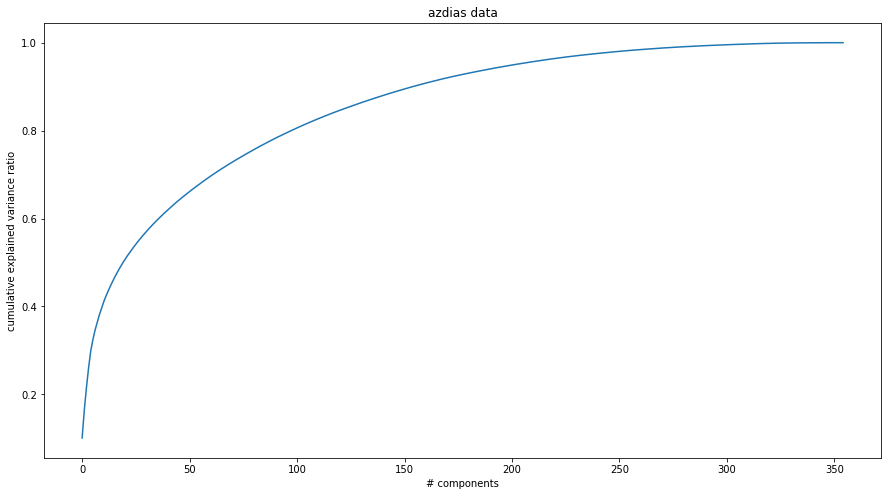

In [94]:
# plot cumulative sum of explained variance ratio 
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('cumulative explained variance ratio')
plt.title('azdias data')
plt.show()

Based on above chart we can see that at about 160 components cumulative variance is quite high, so we will reduce dimension  
and choose 160 components for the features. We will then apply analysis on KMeans clustering to be able to indicate and select the number of cluster we will use for further analysis.

In [95]:
# define PCA with 160 components
pca = PCA(160)



In [245]:
# fit PCA with number of components = 160
pca_160_azd = pca.fit(azdias)


In [ ]:
pca_160_azd.explained_variance_ratio_.sum()

In [ ]:
pca_160_cust = pca.fit(customers)

In [103]:

pca_160_cust.explained_variance_ratio_.sum()

0.9119142449315873


In [96]:
# fit and transfotm pca for azdias dataset
pca_azdias = pca.fit_transform(azdias)


In [109]:

pca_azdias = pd.DataFrame(pca_azdias)

In [97]:
# fit and transfotm pca for customers dataset
pca_customers = pca.fit_transform(customers)


In [108]:
pca_customers = pd.DataFrame(pca_customers)

In [110]:
def KM_score(df, x):
    '''
    this function takes data frame and apply KMeans for the data
    INPUT: df - data frame, x - number of clusters to be taken in KMeans method
    OUTPUT - absolute value of score 
    - the value to evaluate the quality of clusters created using clustering K-Means algorithm
    '''
    km = KMeans(x)
    kmod = km.fit(df)
    return abs(kmod.score(df))

In [111]:
scoring = []
for i in range(1, 20):
    scoring.append(KM_score(pca_azdias.sample(25000), i))

In [112]:
scoring

[598699.1939055084,
 550174.0954011558,
 528701.2332157829,
 510979.23516808206,
 499366.23712179717,
 489307.4554227046,
 482445.53664766054,
 475203.9696105256,
 470822.2439810693,
 465552.0239064576,
 460912.4759387801,
 458341.68590075325,
 454748.972942618,
 448460.7517385512,
 449520.267166136,
 444033.8272254036,
 443874.59872234985,
 439552.7281994563,
 441016.0499828033]

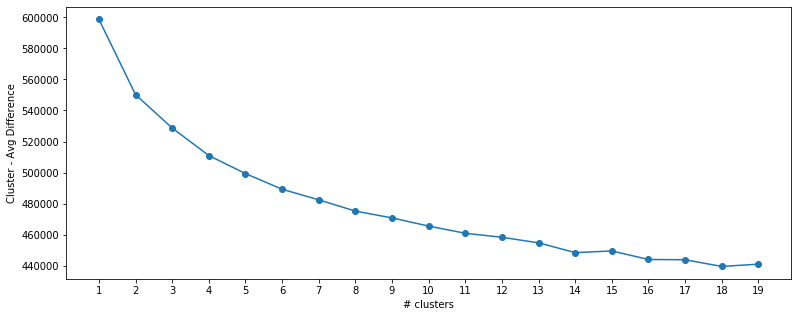

In [253]:
# plot graph with score values for K-Means cluster model  vs cluster
plt.figure(figsize=(13,5))
plt.plot(np.linspace(1,19,19), scoring,  marker='o')
plt.xticks(list(range(1,20,1)))
plt.ylabel('Cluster - Avg Difference')
plt.xlabel('# clusters')
plt.show()

Taking a look at the above chart, I decided to apply KMeans with 10 clusters as scoring values are decreasing for more clusters.

In [115]:
km = KMeans(10)
kmod = km.fit(pca_azdias)
azdias_pred = kmod.predict(pca_azdias)
customers_pred = kmod.predict(pca_customers)

In [116]:

# number of predictions in each population segment
azdias_clust = pd.Series(azdias_pred)
pop_clust = azdias_clust.value_counts().sort_index()



In [117]:
# number of predictions in each customer segment
customer_clust = pd.Series(customers_pred)
cust_clust = customer_clust.value_counts().sort_index()

In [198]:
# dataframe for population and customer segments
df_clust = pd.concat([pop_clust, cust_clust], axis=1).reset_index()
df_clust.columns = ['cluster','general_population','customer']

df_clust['population%'] = (df_clust['general_population']/df_clust['general_population'].sum()*100).round(2)
df_clust['customer%'] = (df_clust['customer']/df_clust['customer'].sum()*100).round(2)



In [199]:
df_clust = pd.DataFrame(df_clust)


In [68]:
df_clust

,cluster,general_population,customer,population%,customer%
0,0,94915,13424,10.65,7.00
1,1,86786,43127,9.74,22.50
2,2,101520,6494,11.39,3.39
3,3,55069,5691,6.18,2.97
4,4,76060,1946,8.53,1.02
5,5,128107,15767,14.37,8.23
6,6,76166,29150,8.55,15.21
7,7,87906,12128,9.86,6.33
8,8,78242,29992,8.78,15.65
9,9,106450,33933,11.94,17.71


<Figure size 936x360 with 0 Axes>

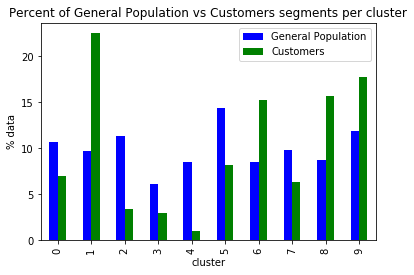

In [72]:
plt.figure(figsize=(13,5))

df_clust.plot(x = 'cluster', y =['population%','customer%'] , color=['blue','green'] ,kind ='bar')
plt.xlabel('cluster') 
plt.ylabel('% data')
plt.legend(('General Population', 'Customers'))
plt.title(('Percent of General Population vs Customers segments per cluster'))
plt.show()

plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [5]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [112]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [5]:
mailout_train.shape

(42962, 367)

In [6]:
mailout_test.shape

(42833, 366)

In [7]:
set(mailout_train.columns) - set(mailout_test.columns)

{'RESPONSE'}

**We will clean data using the same steps like for azdias and customers data sets.**

In [8]:
# replace 'X' with null and set column type as float for all CAMEO_DEUG_2015 column values in train and test datasets
mailout_train['CAMEO_DEUG_2015'] = mailout_train['CAMEO_DEUG_2015'].replace({'X':np.nan}).astype(float)
mailout_test['CAMEO_DEUG_2015'] = mailout_test['CAMEO_DEUG_2015'].replace({'X':np.nan}).astype(float)
 

In [9]:
# replace 'X' with null and set column type as float for all CAMEO_INTL_2015 column values in train and test datasets
mailout_train['CAMEO_INTL_2015'] = mailout_train['CAMEO_INTL_2015'].replace({'XX':np.nan}).astype(float)
mailout_test['CAMEO_INTL_2015'] = mailout_test['CAMEO_INTL_2015'].replace({'XX':np.nan}).astype(float)

In [10]:
# additionally we replce uniformly distributed values with nulls for ALTERSKATEGORIE_GROB                
mailout_train['ALTERSKATEGORIE_GROB'].replace(9, np.nan, inplace=True)         
mailout_test['ALTERSKATEGORIE_GROB'].replace(9, np.nan, inplace=True) 

In [45]:
# apply add_missing_values to azdias dataset
add_missing_values(mailout_train,att_tr)
add_missing_values(mailout_test,att_tr)

In [46]:
# check percentage of nulls
train_percent_nulls = percent_nulls(mailout_train)
test_percent_nulls = percent_nulls(mailout_test)

In [47]:
# find features having 30% nulls or more for training data
train_percent_nulls[train_percent_nulls.percent_nulls >= 30].sort_values('percent_nulls')

,col_name,percent_nulls
ALTER_HH,ALTER_HH,30.671291
EXTSEL992,EXTSEL992,37.121177
AGER_TYP,AGER_TYP,41.811368
KBA05_BAUMAX,KBA05_BAUMAX,53.489130
KK_KUNDENTYP,KK_KUNDENTYP,58.926493
ALTER_KIND1,ALTER_KIND1,95.372655
ALTER_KIND2,ALTER_KIND2,98.240305
TITEL_KZ,TITEL_KZ,99.504213
ALTER_KIND3,ALTER_KIND3,99.594991
ALTER_KIND4,ALTER_KIND4,99.904567


In [48]:
# find features having 30% nulls or more for test data
test_percent_nulls[test_percent_nulls.percent_nulls >= 30].sort_values('percent_nulls')

,col_name,percent_nulls
ALTER_HH,ALTER_HH,30.889735
EXTSEL992,EXTSEL992,36.908458
AGER_TYP,AGER_TYP,42.016669
KBA05_BAUMAX,KBA05_BAUMAX,53.286018
KK_KUNDENTYP,KK_KUNDENTYP,58.447926
ALTER_KIND1,ALTER_KIND1,95.300353
ALTER_KIND2,ALTER_KIND2,98.220998
TITEL_KZ,TITEL_KZ,99.425676
ALTER_KIND3,ALTER_KIND3,99.530736
ALTER_KIND4,ALTER_KIND4,99.908949


In [49]:
test_nul_cust = set(test_percent_nulls[test_percent_nulls.percent_nulls > 30].sort_values('percent_nulls')['col_name'])
test_nul_cust

{'AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ'}

In [50]:
train_nul_cust = set(train_percent_nulls[train_percent_nulls.percent_nulls > 30].sort_values('percent_nulls')['col_name'])
train_nul_cust

{'AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ'}

In [51]:
set(test_nul_cust)- set(train_nul_cust)

set()

In [52]:
set(train_nul_cust) -set(test_nul_cust)

set()

In [53]:
feature_list_train = list(set(mailout_train.columns) - set(train_nul_cust) )
feature_list_test= list(set(mailout_test.columns) - set(test_nul_cust) )


In [54]:
mailout_train = mailout_train[feature_list_train]
mailout_test = mailout_test[feature_list_test]

In [55]:
set(mailout_train.columns) - set(mailout_test.columns)

{'RESPONSE'}

There are the same columns exept for the RESPONSE which is not available in the test dataset.

In [56]:
cat_diff = list(set(categories) - set(feature_list_train))
cat_diff

['TITEL_KZ', 'KK_KUNDENTYP', 'AGER_TYP', 'KBA05_BAUMAX']

In [57]:
#define category list with categorical features by removing those features which are not available in the created above training feature list
categories = list(set(categories) - set(cat_diff))
categories.sort()

In [58]:
# clean data using created in the first part feature_cat_eng function
mailout_train = feature_cat_eng(mailout_train)
mailout_test = feature_cat_eng(mailout_test)


In [59]:
percent_nulls(mailout_train)['percent_nulls'].sum()

0.0

In [60]:
percent_nulls(mailout_test)['percent_nulls'].sum()

0.0

In [61]:
# define X for train dataset
mailout_train_X = mailout_train.drop(['RESPONSE'], inplace=False, axis=1)


In [62]:
# define y for train dataset
mailout_train_y = mailout_train['RESPONSE']

In [63]:
# drop LNR column from mailut train data
mailout_train_X = mailout_train_X.drop(['LNR'], inplace=False, axis=1)


In [101]:
# drop LNR column from mailout test data
mailout_test_X = mailout_test.drop(['LNR'], inplace=False, axis=1)


In [102]:
mailout_train_X.shape

(42962, 356)

In [103]:
mailout_test_X.shape

(42833, 356)

In [104]:
mailout_test_X.head()

,KBA13_BAUMAX,D19_TELKO_ANZ_24,KBA05_CCM3,FINANZ_HAUSBAUER,KBA13_VORB_3,D19_TIERARTIKEL,SEMIO_PFLICHT,D19_VERSI_ANZ_12,D19_GESAMT_DATUM,D19_GARTEN,...,KBA05_MOD8,KBA05_MAXBJ,KBA13_CCM_3000,GEBURTSJAHR,KBA13_KMH_0_140,KBA13_KRSHERST_AUDI_VW,ANREDE_KZ_1.0,ANREDE_KZ_2.0,ANREDE_KZ_nan,PRAEGENDE_JUGENDJAHRE_M
0,2.0,0,3.0,3,0.0,0,1,0,4,0,...,1.0,1.0,4.0,0,1.0,4.0,1,0,0,1.0
1,3.0,0,5.0,5,5.0,0,3,0,9,0,...,0.0,2.0,3.0,0,4.0,3.0,1,0,0,3.0
2,1.0,0,4.0,4,0.0,0,4,0,10,0,...,3.0,4.0,3.0,1946,3.0,3.0,0,1,0,3.0
3,1.0,0,3.0,4,5.0,0,2,0,8,6,...,2.0,1.0,2.0,0,3.0,5.0,0,1,0,3.0
4,1.0,1,5.0,2,4.0,7,3,0,2,5,...,2.0,1.0,1.0,1956,1.0,5.0,0,1,0,4.0


In [105]:
mailout_train_X.head()

,KBA13_BAUMAX,D19_TELKO_ANZ_24,KBA05_CCM3,FINANZ_HAUSBAUER,KBA13_VORB_3,D19_TIERARTIKEL,SEMIO_PFLICHT,D19_VERSI_ANZ_12,D19_GESAMT_DATUM,D19_GARTEN,...,KBA05_MOD8,KBA05_MAXBJ,KBA13_CCM_3000,GEBURTSJAHR,KBA13_KMH_0_140,KBA13_KRSHERST_AUDI_VW,ANREDE_KZ_1.0,ANREDE_KZ_2.0,ANREDE_KZ_nan,PRAEGENDE_JUGENDJAHRE_M
0,5.0,0,2.0,5,2.0,0,3,0,9,0,...,0.0,3.0,3.0,0,3.0,3.0,0,1,0,2.0
1,1.0,1,3.0,3,3.0,6,5,0,1,0,...,2.0,1.0,2.0,1957,4.0,4.0,0,1,0,4.0
2,1.0,0,2.0,2,2.0,0,1,0,6,0,...,0.0,4.0,2.0,1929,1.0,4.0,1,0,0,1.0
3,1.0,0,2.0,5,3.0,0,4,0,10,0,...,0.0,4.0,5.0,1924,5.0,3.0,0,1,0,1.0
4,1.0,0,4.0,5,0.0,0,4,0,7,0,...,1.0,4.0,4.0,1936,1.0,3.0,1,0,0,2.0


In [106]:
# change data type as float in mailout_train_X dataset
mailout_train_X.astype(float);

In [107]:
#scalling data and fitting it using scaler
MMscaler = MinMaxScaler()
MMscaler.fit(mailout_train_X.astype(float))


MinMaxScaler()

In [108]:

# transform scaled data
mailout_train_X_sc = MMscaler.transform(mailout_train_X)
mailout_test_X_sc = MMscaler.transform(mailout_test_X)

In [109]:
mailout_train_y.unique()

array([0, 1], dtype=int64)

In [307]:
# split data into train and validation datasets
X_train, X_test, y_train, y_test = train_test_split(mailout_train_X_sc, mailout_train_y, test_size=0.2, random_state=40)


In [145]:
#apply RandomForestClassifier model
model = RandomForestClassifier(n_estimators=250, random_state=40)


In [146]:
# model fitting
model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=250, random_state=40)

In [160]:
# model prediction
y_pred = model.predict_proba(X_test)[:,1]

In [312]:
print("ROC score on test data: {:.4f}".format(roc_auc_score(y_test, y_pred)))

In [162]:
# get parameters' values for RandomForestClassifier model
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 250,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 40,
 'verbose': 0,
 'warm_start': False}

In [163]:
# RandomForestClassifier with different parameters
model2 = RandomForestClassifier(n_estimators=250,max_depth=5, random_state=40)

In [164]:
# model fitting
model2.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=250, random_state=40)

In [165]:
# model prediction
y_pred_RFC = model2.predict_proba(X_test)[:,1]

In [311]:
print("ROC score on test data: {:.4f}".format(roc_auc_score(y_test, y_pred_RFC)))

In [308]:
parameters = { 
                'n_estimators' :[200, 250, 500],
                'max_depth' : [3,4,5],
                'random_state' : [42]
            }

In [122]:
#use GridSearchCV for hyper parameter tuning
cv = GridSearchCV(model, param_grid=parameters)

In [123]:
# fitting model 
cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=200,
                                              random_state=40),
             param_grid={'max_depth': [3, 4, 5],
                         'n_estimators': [200, 250, 500],
                         'random_state': [42]})

In [ ]:
y_pred_cv = cv.predict_proba(X_test)[:,1]

In [ ]:
print("ROC score on test data: {:.4f}".format(roc_auc_score(y_test, y_pred_cv)))

In [124]:
# get the best parameters for RandomForestClassifier model
cv.best_params_

{'max_depth': 3, 'n_estimators': 200, 'random_state': 42}

In [167]:
# best parameters' set
parameters = { 
                'n_estimators' :[200],
                'max_depth' : [3],
                'random_state' : [42]
                
             }

In [168]:

cv_best = GridSearchCV(model, param_grid=parameters)

In [169]:
# fitting model with the best parameter set
cv_best.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_estimators=250,
                                              random_state=40),
             param_grid={'max_depth': [3], 'n_estimators': [200],
                         'random_state': [42]})

In [174]:
# model prediction
y_pred_cv_best = cv_best.predict_proba(X_test)[:,1]

In [310]:
print("ROC score on test data: {:.4f}".format(roc_auc_score(y_test, y_pred_cv_best)))

In [176]:
# define GradientBoostingClassifier model
GBC_model = GradientBoostingClassifier(random_state=40)

In [177]:
GBC_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 40,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [74]:
# search the best parameters' set for GradientBoostingClassifier model by applying GradientBoostingClassifier
GBC_model = BayesSearchCV(
    estimator = GradientBoostingClassifier(),
    
    search_spaces = {
        'learning_rate': [0.001, 1.0],
        'max_depth': [3, 5],
        'n_estimators': [200, 250, 300]
        },    
    scoring = 'roc_auc',
    
    random_state = 40
)

In [178]:
GBC_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=40)

In [180]:
y_pred_gbc = GBC_model.predict_proba(X_test)[:,1]

In [309]:
print("ROC score on test data using GradientBoostingClassifier: {:.4f}".format(roc_auc_score(y_test, y_pred_gbc)))

In [122]:
# define GradientBoostingClassifier with setting parameters
gbc_6 = GradientBoostingClassifier(
                             
                              learning_rate= 0.003,
                              max_depth =6,
                              n_estimators = 250,
                              subsample=0.6

                              )

In [114]:
# fitting model
gbc_6.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.003, max_depth=6, n_estimators=250,
                           subsample=0.6)

In [115]:
# model prediction
y_pred_gbc_6 = gbc_6.predict_proba(X_test)[:,1]

In [313]:
print("ROC score on test data using GradientBoostingClassifier: {:.6f}".format(roc_auc_score(y_test, y_pred_gbc_6)))

In [221]:
# define model using BayesSearchCV to find the best parameters' set
xgb_model = BayesSearchCV(
    estimator = xgbc.XGBClassifier(
        eval_metric = 'auc',
        verbosity=1,use_label_encoder=False),
    
    search_spaces = {
        'booster': ['gbtree'],
        'learning_rate': [0.002, 0.003],
        'max_depth': [5, 7],
        'n_estimators': [200,250],
        'subsample': [0.5,0.6]
        },    
    scoring = 'roc_auc',
    verbose = 0,
    refit = True,
    random_state = 40
)

In [223]:
# fitting model
xgb_model.fit(X_train, y_train)

In [ ]:
#model prediction 
y_pred_xgb = xgb_model.predict_proba(X_test)[:,1]

In [ ]:
roc_auc_score(y_test, y_pred_xgb)

In [225]:
param_xgbc = {
                'booster': ['gbtree'],
                'learning_rate': [0.002, 0.003],
                'max_depth': [5, 7],
                'n_estimators': [200,250],
                'subsample': [0.5,0.6],
                'eval_metric': [ 'auc'],
                'verbosity':  [1]
}

In [226]:
# use GridSearchCV to define model with the highest score
cv_xgbc = GridSearchCV(xgbc.XGBClassifier(random_state=40, use_label_encoder=False), param_grid=param_xgbc)

In [228]:
# fitting model
cv_xgbc.fit(X_train, y_train)

In [ ]:
#  model prediction
y_pred_cv_xgbc = cv_xgbc.predict_proba(X_test)[:,1]

In [ ]:
# check roc_auc_score
roc_auc_score(y_test, y_pred_cv_xgbc)

Below we will define and fit XGBClassifier model with different parameters.

In [ ]:
xgb_6 = xgbc.XGBClassifier(booster='gbtree',
                              learning_rate=0.003,
                              max_depth=6,
                              n_estimators=250,
                              subsample=0.6,
                              eval_metric='auc',
                              verbosity=1,
                              use_label_encoder=False
                              )

In [ ]:
xgb_6.fit(X_train, y_train)

In [ ]:
y_pred_6 = xgb_6.predict_proba(X_test)[:,1]

In [ ]:
roc_auc_score(y_test, y_pred_6)

In [ ]:
xgbc_5 = xgbc.XGBClassifier(booster='gbtree',
                              learning_rate=0.003,
                              max_depth=5,
                              n_estimators=250,
                              subsample=0.6,
                              eval_metric='auc',
                              verbosity=1,
                              use_label_encoder=False
                              )

In [ ]:
xgbc_5.fit(X_train, y_train)

In [ ]:
y_pred_xgbc_5 = xgbc_5.predict_proba(X_test)[:,1]

In [ ]:
roc_auc_score(y_test, y_pred_xgbc_5)

In [315]:
xgbc_7 = xgbc.XGBClassifier(booster='gbtree',
                              learning_rate=0.0031,
                              max_depth=6,
                              n_estimators=250,
                              subsample=0.5,
                              eval_metric='auc',
                              verbosity=1,
                              use_label_encoder=False
                              )

In [317]:
xgbc_7.fit(X_train, y_train)

In [112]:
y_pred_xgbc_7 = xgbc_7.predict_proba(X_test)[:,1]

In [113]:
roc_auc_score(y_test, y_pred_xgbc_7)

0.7760777847825032

In [230]:
xgbc_7 = xgbc.XGBClassifier(booster='gbtree',
                              learning_rate=0.0031,
                              max_depth=6,
                              n_estimators=250,
                              subsample=0.4,
                              eval_metric='auc',
                              verbosity=1,
                              use_label_encoder=False
                              )

In [231]:
xgbc_7.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0031,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

In [232]:
y_pred_xgbc_7 = xgbc_7.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_xgbc_7)

0.7813515348431213

In [217]:
xgbc_5_03_32 = xgbc.XGBClassifier(booster='gbtree',
                              learning_rate=0.0031,
                              max_depth=5,
                              n_estimators=250,
                              subsample=0.4,
                              eval_metric='auc',
                              verbosity=1,
                              use_label_encoder=False
                              )

In [219]:
xgbc_5_03_32.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0031,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

In [220]:
y_pred_xgbc_5_03_32 = xgbc_5_03_32.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_xgbc_5_03_32)

0.7826585704355938

In [272]:
# feature importance for xgbc_5_03_32 model: XGBClassifier with max_depth=5, subsample=0.4
feature_importance = pd.Series(xgbc_5_03_32.feature_importances_,
                     index=mailout_train_X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
feature_most_imp = list(feature_importance.sort_values(ascending=False)[:190].index)
feature_most_imp

['REGIOTYP',
 'D19_TELKO_MOBILE',
 'KBA05_SEG7',
 'RELAT_AB',
 'ZABEOTYP',
 'KBA13_SEG_VAN',
 'KBA13_TOYOTA',
 'KBA13_MAZDA',
 'PLZ8_ANTG2',
 'KBA05_HERST4',
 'D19_DROGERIEARTIKEL',
 'KBA05_MAXSEG',
 'SEMIO_KRIT',
 'KBA13_KW_121',
 'KBA13_KMH_0_140',
 'KBA13_KW_90',
 'KBA05_CCM1',
 'KBA05_CCM4',
 'KBA13_CCM_0_1400',
 'EWDICHTE',
 'KBA13_KW_60',
 'KBA13_BJ_2008',
 'KBA05_ANTG3',
 'KBA05_KRSOBER',
 'KBA05_CCM3',
 'KBA13_GBZ',
 'KBA13_KMH_180',
 'KBA13_CCM_1401_2500',
 'D19_BIO_OEKO',
 'KBA05_VORB1',
 'SEMIO_KULT',
 'KBA05_ZUL4',
 'KBA13_FORD',
 'KBA13_HALTER_20',
 'D19_WEIN_FEINKOST',
 'KBA13_CCM_3000',
 'KBA13_SEG_MITTELKLASSE',
 'LP_FAMILIE_GROB',
 'GEBAEUDETYP_RASTER',
 'SEMIO_TRADV',
 'D19_DIGIT_SERV',
 'KBA13_HHZ',
 'INNENSTADT',
 'KBA05_ANTG1',
 'LP_STATUS_FEIN',
 'KBA05_FRAU',
 'KBA13_NISSAN',
 'KBA13_KRSSEG_OBER',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'FINANZ_MINIMALIST',
 'KBA13_SEG_SPORTWAGEN',
 'VK_DHT4A',
 'KBA13_AUDI',
 'FINANZTYP',
 'D19_SONSTIGE',
 'KBA05_KW2',
 'KBA05_SEG2',
 '

In [273]:
# fit mailout_train_X dataset with selected above features
MMscaler.fit(mailout_train_X[feature_most_imp].astype(float))


MinMaxScaler()

In [274]:
# transform scaled data with the selected features

mailout_train_X_sc = MMscaler.transform(mailout_train_X[feature_most_imp])
mailout_test_X_sc = MMscaler.transform(mailout_test_X[feature_most_imp])

In [283]:
# splitting dataset into X_train, X_test, y_train, y_test sets
X_train, X_test, y_train, y_test = train_test_split(mailout_train_X_sc, mailout_train_y, test_size=0.2, random_state=40)


In [287]:
X_train.shape, X_test.shape

((34369, 190), (8593, 190))

In [285]:
xgbc_5_03_32.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0031,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.4,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=1)

In [286]:
# the highest roc auc score
y_pred_xgbc_5_03_32 = xgbc_5_03_32.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred_xgbc_5_03_32)

0.7847322770823086

In [244]:
# we need to redefine mailout_train_X_sc, mailout_test_X_sc once again to obtain all features 
#after removing some fetures above
mailout_train_X = mailout_train.drop(['RESPONSE'], inplace=False, axis=1)
mailout_train_y = mailout_train['RESPONSE']
mailout_train_X = mailout_train_X.drop(['LNR'], inplace=False, axis=1)
mailout_test_X = mailout_test.drop(['LNR'], inplace=False, axis=1)
MMscaler = MinMaxScaler()
MMscaler.fit(mailout_train_X.astype(float))
mailout_train_X_sc = MMscaler.transform(mailout_train_X)
mailout_test_X_sc = MMscaler.transform(mailout_test_X)
X_train, X_test, y_train, y_test = train_test_split(mailout_train_X_sc, mailout_train_y, test_size=0.2, random_state=40)


In [245]:
X_train.shape, X_test.shape

((34369, 356), (8593, 356))

In [300]:
reg = xgbc.XGBRegressor(booster='gbtree',
             learning_rate=0.0032,
             max_depth=7,
             n_estimators=247,
             subsample=0.7,
             eval_metric='auc',
             verbosity=1,
             use_label_encoder=False,
             random_state = 40 
                              ) 

In [301]:
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0032, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=247, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=40,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=1)

In [302]:
y_reg = reg.predict(X_test)
roc_auc_score(y_test, y_reg)

0.7932256991832183

In [303]:
feature_importance = pd.Series(reg.feature_importances_,
                     index=mailout_train_X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
feature_most_imp = list(feature_importance.sort_values(ascending=False)[:160].index)
feature_most_imp;

In [127]:
reg2 = xgbc.XGBRegressor(booster='gbtree',
             learning_rate=0.0032,
             max_depth=6,
             n_estimators=247,
             subsample=0.5,
             eval_metric='auc',
             verbosity=1,
             use_label_encoder=False,
             random_state = 40
             )
                         

In [128]:
reg2.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0032, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=247, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=40,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=1)

In [129]:
y_reg2 = reg2.predict(X_test)
roc_auc_score(y_test, y_reg2)

0.784038347408213

In [240]:
# scal, fit and transform data for data with the most import fetures for reg model
MMscaler.fit(mailout_train_X[feature_most_imp].astype(float))
mailout_train_X_sc = MMscaler.transform(mailout_train_X[feature_most_imp])
mailout_test_X_sc = MMscaler.transform(mailout_test_X[feature_most_imp])
X_train, X_test, y_train, y_test = train_test_split(mailout_train_X_sc, mailout_train_y, test_size=0.2, random_state=40)


In [241]:
X_train.shape, X_test.shape

((34369, 160), (8593, 160))

In [242]:
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0032, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=247, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=40,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=1)

In [243]:
y_reg = reg.predict(X_test)
roc_auc_score(y_test, y_reg)

0.7932256991832183

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

For Kaggle Competion the below XGBClassifier model has been chosen with the tuned paremeter giving best roc_auc score with 190 selected features (feature selection has been done based on feature importances for the best performing XGBClassifier model). The same model has been applied with those 190 features to get the best score for the Kaggle submission.

In [304]:
xgbc_best = xgbc.XGBRegressor(booster='gbtree',
             learning_rate=0.0032,
             max_depth=7,
             n_estimators=247,
             subsample=0.7,
             eval_metric='auc',
             verbosity=1,
             use_label_encoder=False,
             random_state = 40 
                              ) 

In [305]:
mailout_train_X_sc.shape, mailout_test_X_sc.shape

((42962, 356), (42833, 356))

In [306]:
xgbc_best.fit(mailout_train_X_sc, mailout_train_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.0032, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=247, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=40,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', use_label_encoder=False,
             validate_parameters=1, verbosity=1)

In [307]:
feature_importance = pd.Series(xgbc_best.feature_importances_,
                     index=mailout_train_X.columns)
feature_importance = feature_importance.sort_values(ascending=False)

In [308]:
# the top 20 most significant features for the model
feature_most_imp = list(feature_importance.sort_values(ascending=False)[:20].index)
feature_most_imp

['KBA13_HALTER_40',
 'KBA13_RENAULT',
 'PLZ8_HHZ',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'KBA13_HALTER_20',
 'SEMIO_RAT',
 'KBA05_VORB2',
 'UMFELD_ALT',
 'KBA05_ANTG3',
 'D19_VERSAND_DATUM',
 'KBA13_SEG_SPORTWAGEN',
 'KBA05_VORB1',
 'CJT_KATALOGNUTZER',
 'D19_BEKLEIDUNG_REST',
 'SEMIO_TRADV',
 'KBA05_SEG4',
 'D19_FREIZEIT',
 'KBA05_ALTER4',
 'LP_FAMILIE_FEIN',
 'KBA13_CCM_3001']

In [309]:
feature_importance_top = feature_importance.sort_values(ascending=False)[:20]
feature_importance_df = pd.DataFrame(feature_importance_top,columns =['value'])

<Figure size 936x360 with 0 Axes>

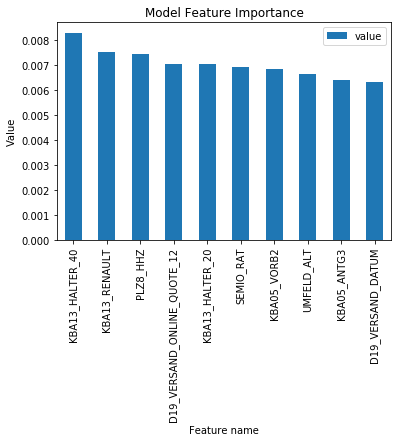

In [310]:
plt.figure(figsize=(13,5))
feature_importance_df[:10].plot(kind='bar')
plt.xlabel('Feature name') 
plt.ylabel('Value')
plt.title(('Model Feature Importance'))
plt.show()

In [313]:
feature_importance_df

,value
KBA13_HALTER_40,0.008278
KBA13_RENAULT,0.007507
PLZ8_HHZ,0.007411
D19_VERSAND_ONLINE_QUOTE_12,0.007031
KBA13_HALTER_20,0.007017
SEMIO_RAT,0.006891
KBA05_VORB2,0.006803
UMFELD_ALT,0.006618
KBA05_ANTG3,0.006394
D19_VERSAND_DATUM,0.006309


In [262]:
y_pred_proba = xgbc_best.predict(mailout_test_X_sc)


In [263]:
y_pred_proba = pd.DataFrame(y_pred_proba)

In [264]:
LNR = pd.DataFrame(mailout_test['LNR'])

In [265]:
result = pd.concat([LNR,y_pred_proba], axis=1)
result = result.loc[~np.isnan(result['LNR'])]



In [266]:
#change LNR column type from float to int
result['LNR'] = result['LNR'].astype(int)
result = result.rename(columns={0: "RESPONSE"})
result.set_index('LNR', inplace = True)



In [267]:
result.head()

,RESPONSE
LNR,
1754,0.250130
1770,0.247364
1465,0.233720
1470,0.233795
1478,0.233797


In [268]:
result.to_csv('submission5.csv')

In [269]:
result.RESPONSE.min(),result.RESPONSE.max()

(0.2336878478527069, 0.42628100514411926)